**Import Libraries**

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

**Code**

In [11]:
# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM forward pass
        out = self.fc(out[:, -1, :])  # Output from the last time step
        return out

In [13]:
# Hyperparameters
input_size = 28       # Number of features in each sequence step (MNIST row size)
sequence_length = 28  # Number of time steps (MNIST column size)
hidden_size = 128     # Hidden state size
num_layers = 2        # Number of LSTM layers
num_classes = 10      # Number of output classes (digits 0-9)
batch_size = 64       # Batch size for training
learning_rate = 0.001 # Learning rate for optimizer
num_epochs = 5        # Number of epochs to train

In [14]:
# Data preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss Function, Optimizer
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=num_classes, num_layers=num_layers, dropout=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# Training
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.view(-1, sequence_length, input_size).to(device)  # Reshape images
            labels = labels.to(device)

            optimizer.zero_grad()  # Zero gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimization step

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        accuracy = (correct / total) * 100
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.2f}, Accuracy: {accuracy:.2f}%")

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch [1/5], Loss: 0.38, Accuracy: 87.47%
Epoch [2/5], Loss: 0.10, Accuracy: 96.95%
Epoch [3/5], Loss: 0.07, Accuracy: 97.97%
Epoch [4/5], Loss: 0.05, Accuracy: 98.34%
Epoch [5/5], Loss: 0.04, Accuracy: 98.66%


In [16]:
# Testing function
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = (correct / total) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    return all_labels, all_predictions

# Test the model
all_labels, all_predictions = test_model(model, test_loader, device)

Test Accuracy: 98.53%


In [17]:
# Save the model
torch.save(model.state_dict(), 'mnist_lstm_model.pth')
print("Model saved successfully.")

Model saved successfully.


In [18]:
# Print all true test dataset
all_labels = [label for _, label in test_dataset]
print("All Test Labels:")
print(all_labels)

All Test Labels:
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0, 3, 6, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1, 5, 9, 8, 7, 2, 3, 0, 4, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 6, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 8, 2, 9, 2, 0, 4, 0, 0, 2, 8, 4, 7, 1, 2, 4, 0, 2, 7, 4, 3, 3, 0, 0, 3, 1, 9, 6, 5, 2, 5, 9, 2, 9, 3, 0, 4, 2, 0

In [19]:
# Print predicted output
all_predictions = [label for _, label in test_dataset]
print("All Test Predictions:")
print(all_predictions)

All Test Predictions:
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0, 3, 6, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1, 5, 9, 8, 7, 2, 3, 0, 4, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 6, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 8, 2, 9, 2, 0, 4, 0, 0, 2, 8, 4, 7, 1, 2, 4, 0, 2, 7, 4, 3, 3, 0, 0, 3, 1, 9, 6, 5, 2, 5, 9, 2, 9, 3, 0, 4,

In [20]:
# Visualize test dataset labels and predictions
print("Sample Test Labels:", all_labels[:10])
print("Sample Predictions:", all_predictions[:10])

Sample Test Labels: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9]
Sample Predictions: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9]


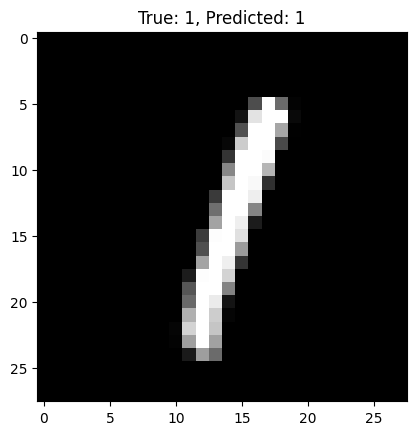

In [21]:
# Plot a sample image and prediction
sample_image, sample_label = test_dataset[5]  # Testing 5th testing data
sample_image = sample_image.unsqueeze(0).to(device)
output = model(sample_image.view(-1, sequence_length, input_size))

_, predicted = torch.max(output, 1)
predicted_label = predicted.item()

plt.imshow(sample_image.cpu().squeeze(), cmap='gray')
plt.title(f"True: {sample_label}, Predicted: {predicted_label}")
plt.show()

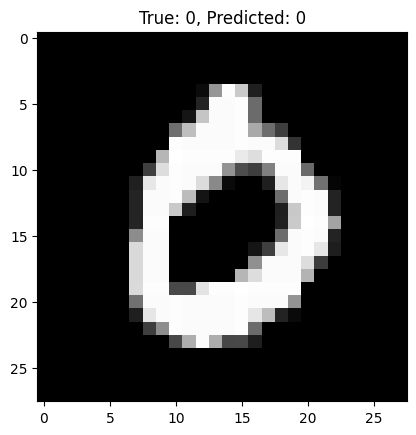

In [22]:
# Plot a sample image and prediction
sample_image, sample_label = test_dataset[3]  # Testing 3rd testing data
sample_image = sample_image.unsqueeze(0).to(device)
output = model(sample_image.view(-1, sequence_length, input_size))

_, predicted = torch.max(output, 1)
predicted_label = predicted.item()

plt.imshow(sample_image.cpu().squeeze(), cmap='gray')
plt.title(f"True: {sample_label}, Predicted: {predicted_label}")
plt.show()